# Exercício 1 - Técnicas de Modelagem de Sistemas Dinâmicos
## Aluna: Renata Miranda Rabelo Nésio
### Matrícula: 2014140418

## Modelo de tanques acoplados

Em [Cocota Júnior, 2009](http://www.pee.coppe.ufrj.br/index.php/pt/producao-academica/dissertacoes-de-mestrado/2009-1/2009092801-2009092801/file) é apresentado o seguinte modelo de tanques acoplados:

![tanques4](tanques4.png)

E a dinâmica do nível de cada tanque pode ser expressa por:

- Tanque 1:
$$ \dot{h_1} = -\frac{a_{1}}{A_{1}}\sqrt{2 g h_{1}} + \frac{a_{3}}{A_{1}} \sqrt{2 g h_{3}} + \frac{\gamma_{1} k_{1}}{A_{1}} v_{1}, $$

- Tanque 2:
$$ \dot{h_2} = -\frac{a_{2}}{A_{2}}\sqrt{2 g h_{2}} + \frac{a_{4}}{A_{2}} \sqrt{2 g h_{4}} + \frac{\gamma_{2} k_{2}}{A_{2}} v_{2}, $$

onde $A_{2} := b(c + h_{2}tan(\theta))$, 

- Tanque 3:
$$ \dot{h_3} = -\frac{a_{3}}{A_{3}}\sqrt{2 g h_{3}} + \frac{(1 -\gamma_{2}) k_{2}}{A_{3}} v_{2}, $$

- Tanque 4:
$$ \dot{h_4} = -\frac{a_{4}}{A_{4}}\sqrt{2 g h_{4}} + \frac{(1 -\gamma_{1}) k_{1}}{A_{4}} v_{1}. $$


De forma compacta, o sistema não linear MIMO considerado é dado por:

$$ \dot{x_{h}} = f_{h}(x_{h}, u_{h}), \text{ } y_{h} = [h_{1} \text{ } h_{2}]^{T},$$

onde $x_{h} := [[h_{1} \text{ } h_{2} \text [h_{3} \text{ } h_{4}]^{T}$ é o estado do sistema, $y_{h}$ é a saída de interesse (medida) e $u_{h} = [v_{1} \text{ } v_{2}]$ é a entrada de controle.

## Parâmetros do modelo

A tabela abaixo descreve cada parâmetro apresentado:

![tabela](tabela.png)

## Simulações

A fim de incentivar o uso de software livre, foi utilizado o código fonte desenvolvido em Python e disponível no [GitHub](https://github.com/felipefrocha/esufmg-tmsd) por um de nossos colegas. 

As funções de plot foram modificadas para melhor atender ao problema atual. O repositório original foi [bifurcado](https://github.com/renatanesio/esufmg-tmsd) para que alterações paralelas fossem feitas.

Todo o desenvolvimento do exercício pode ser visto a seguir.

## Importando bibliotecas

In [1]:
import math
from math import pi

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

## Representação em espaço de estados

In [2]:
def dvCord(x, ux, uy, t):

    gamma1 = 0.75
    gamma2 = 0.75
    theta = 23.5
    k1 = 4470
    k2 = 4190
    b = 78
    c = 76
    a1 = 37.4
    a2 = 37.4
    a3 = 16.6
    a4 = 16.6
    g = 9787.9
    A1 = 11664
    A2 = b * (c + x[1] * np.tan(pi * theta/180))
    A3 = 11664
    A4 = 11664

    xd = np.array(np.zeros((4, 1)))
    
    z0 = 2*g*x[0] if 2*g*x[0] > 0 else 0
    z1 = 2*g*x[1] if 2*g*x[1] > 0 else 0
    z2 = 2*g*x[2] if 2*g*x[2] > 0 else 0
    z3 = 2*g*x[3] if 2*g*x[3] > 0 else 0

    xd[0] = -(a1/A1) * np.sqrt(z0) + (a3/A1) * np.sqrt(z2) + (gamma1*k1/A1) * ux
    xd[1] = -(a2/A2) * np.sqrt(z1) + (a4/A2) * np.sqrt(z3) + (gamma2*k2/A2) * uy
    xd[2] = -(a3/A3) * np.sqrt(z2) + ((1 - gamma2) * k2/A3) * uy
    xd[3] = -(a4/A4) * np.sqrt(z3) + ((1 - gamma1) * k1/A4) * ux

    return xd.copy()

## Runge Kutta

In [3]:
def rk_cord(x0, ux, uy, h, t):
    # 1st evaluation
    xd = dvCord(x0, ux, uy, t)
    savex0 = x0.copy()
    phi = xd.copy()
    for i in range(len(x0)):
        x0[i] = savex0[i] + 0.5 * h * xd[i]

    # 2nd evaluation
    xd = dvCord(x0.T, ux, uy, t + 0.5 * h)
    phi = (phi + 2 * xd)
    for i in range(len(x0)):
        x0[i] = savex0[i] + 0.5 * h * xd[i]

    # 3rd evaluation
    xd = dvCord(x0, ux, uy, t + 0.5 * h)
    phi = phi + 2 * xd
    for i in range(len(x0)):
        x0[i] = savex0[i] + h * xd[i]

    # 4th evaluation
    xd = dvCord(x0, ux, uy, t + h)

    result_x = x0.copy()
    for i in range(len(x0)):
        result_x[i] = savex0[i] + (phi[i] + xd[i]) * h / 6

    return result_x

## Execução e plots

In [4]:
def run_rk(t:np.ndarray, x:np.ndarray, ux, uy, h):
    result = None
    
    for k in range(1, len(t)):
        result = rk_cord(x[:, k - 1].copy(), ux[k], uy[k], h, t[k])
        x[:, k] = result
    
    fig, ax1 = plt.subplots()
    ax1.set_ylabel('v1 (V)')
    ax1.set_xlabel('time')
    ax1.plot(t, ux, label="v1", color='red')
    ax2 = ax1.twinx()
    ax2.plot(t, x[0], label="h1", color='blue')
    ax2.set_ylabel('h1')
    plt.grid()
    plt.show()

    fig, ax3 = plt.subplots()
    ax3.set_ylabel('v2 (V)')
    ax3.set_xlabel('time')
    ax3.plot(t, uy, label="v2", color='red')
    ax4 = ax3.twinx()
    ax4.plot(t, x[1], label="h2", color='blue')
    ax4.set_ylabel('h2')
    plt.grid()
    plt.show()
    
    fig, ax5 = plt.subplots()
    ax5.set_ylabel('v2 (V)')
    ax5.set_xlabel('time')
    ax5.plot(t, uy, label="v2", color='red')
    ax6 = ax5.twinx()
    ax6.plot(t, x[2], label="h2", color='blue')
    ax6.set_ylabel('h3')
    plt.grid()
    plt.show()

    fig, ax7 = plt.subplots()
    ax7.set_ylabel('v1 (V)')
    ax7.set_xlabel('time')
    ax7.plot(t, ux, label="v1", color='red')
    ax8 = ax7.twinx()
    ax8.plot(t, x[3], label="h4", color='blue')
    ax8.set_ylabel('h4')
    plt.grid()
    plt.show()

## Degrau

Primeiro é aplicada uma entrada degrau ao sistema, que significa bombear água para os tanques a uma vazão determinada. Observa-se o nível de água nos tanques se estabilizando após um tempo, definindo, assim, pontos de operação. 

L: 5; R: 45


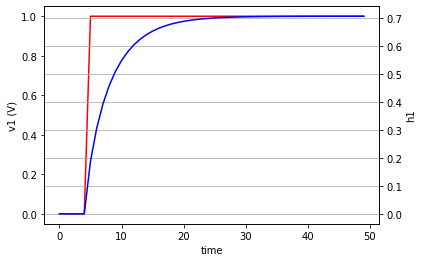

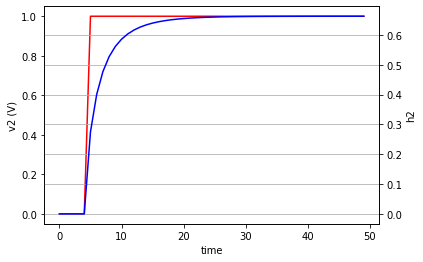

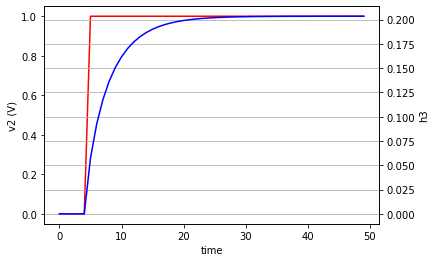

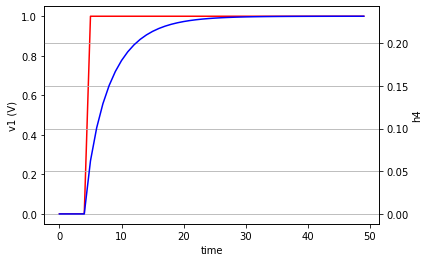

In [5]:
t0 = 0
tf = 50
h = 1
t = np.arange(t0, tf, h)

x0 = np.array([[0], [0], [0], [0]])

z_x = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, z_x, axis=1)


left_size = math.floor(len(t)/10)
right_size = math.floor(len(t) - len(t)/10)
print(f'L: {left_size}; R: {right_size}')
left = np.zeros((left_size, 1))
right = np.ones(right_size)
# print(f'L: {left}; R: {right}')
ux = 1 * np.append(left,right)
uy = ux
run_rk(t.copy(), x.copy(), ux.copy(), uy.copy(), h)

## Degrau de maior amplitude 

Aplicando um degrau de maior amplitude, observa-se que o sistema responde praticamente de forma instantânea, o que faz sentido fisicamente (o tanque começa a encher assim que entra mais água), mas o sistema demora um pouco mais a se estabilizar.

L: 20; R: 180


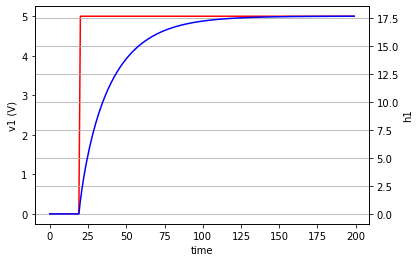

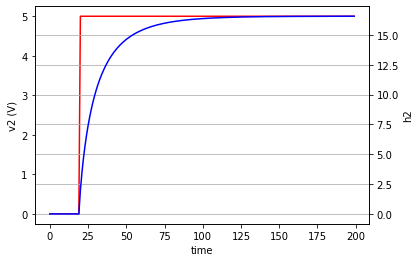

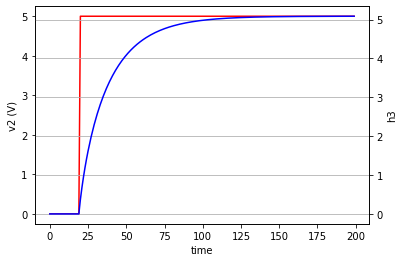

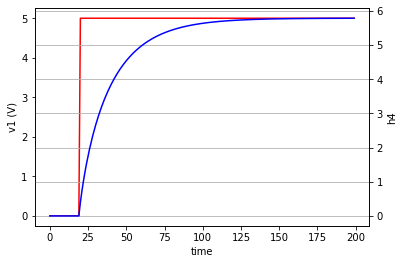

In [6]:
t0 = 0
tf = 200
h = 1
t = np.arange(t0, tf, h)

x0 = np.array([[0], [0], [0], [0]])

z_x = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, z_x, axis=1)


left_size = math.floor(len(t)/10)
right_size = math.floor(len(t) - len(t)/10)
print(f'L: {left_size}; R: {right_size}')
left = np.zeros((left_size, 1))
right = np.ones(right_size)
# print(f'L: {left}; R: {right}')
ux = 5 * np.append(left,right)
uy = ux
run_rk(t.copy(), x.copy(), ux.copy(), uy.copy(), h)

## Impulso

Duurante o esvaziamento dos tanques foi também simulada uma entrada de impulso, à qual o sistema responde igualmente rápido, mas não sofre grandes mudanças em sua dinâmica. Fisicamente, significa bombear uma quantidade significativa de água por um curto espaço de tempo. Embora o volume se altere, não é tão significativo.

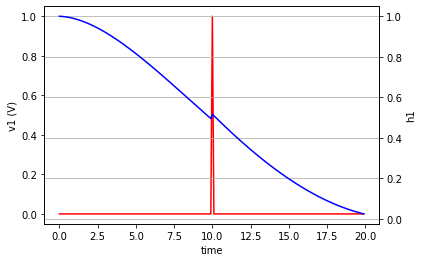

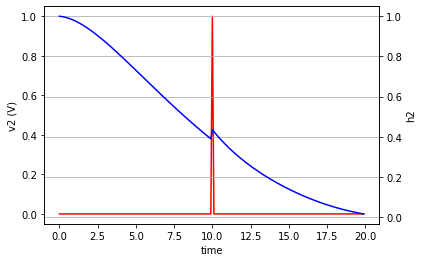

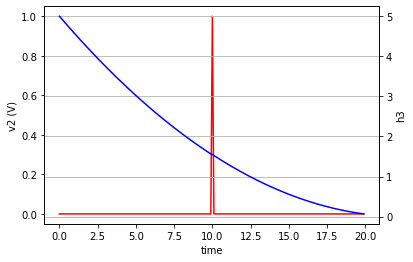

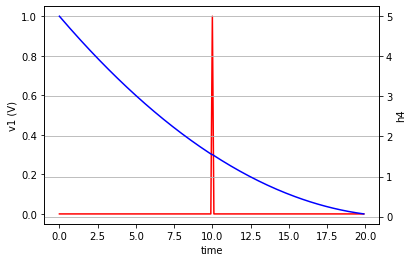

In [12]:
t0 = 0
tf = 20
h = 0.1
t = np.arange(t0, tf, h)

x0 = np.array([[1], [1], [5], [5]])

z_x = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, z_x, axis=1)

#impulso
ux = signal.unit_impulse(len(t),'mid')
uy = ux
run_rk(t.copy(), x.copy(), ux.copy(), uy.copy(), h)

## Pulso

Com um pulso curto demais, o sistema não chega a se estabilizar, como no caso do degrau, e os tanques começam a se esvaziar assim que o pulso se encerra.

49


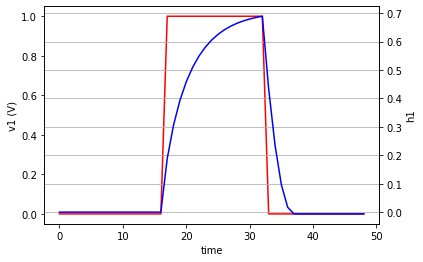

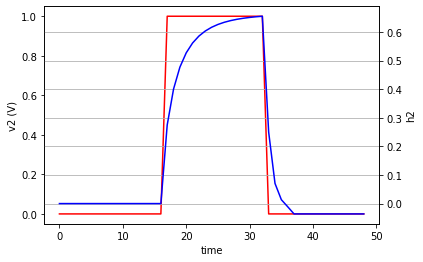

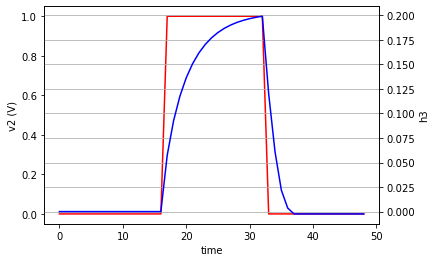

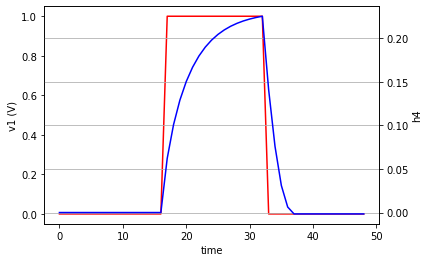

In [22]:
t0 = 0
tf = 49
h = 1
t = np.arange(t0, tf, h)

x0 = np.array([[0], [0], [0], [0]])

z_x = np.zeros((len(x0), len(t)-1))
x = x0.copy()
x = np.append(x, z_x, axis=1)


ux = 1 * np.append(np.append(np.zeros((math.floor(len(t)/3+1), 1)), np.full((math.floor(len(t)/3), 1), 1)), 
                   np.zeros((math.floor(len(t)/3), 1)))
uy = ux
print(len(ux))
run_rk(t.copy(), x.copy(), ux.copy(), uy.copy(), h)

## Pulso mais longo

Com um pulso mais longo, entretanto, observa-se que o sistema atinge um patamar, e os tanques começam a se esvaziar assim que o pulso se encerra.

199


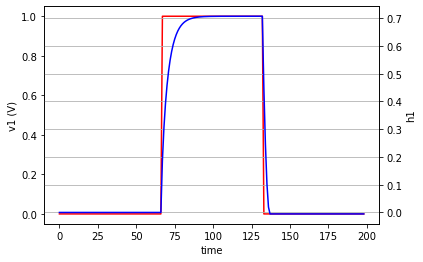

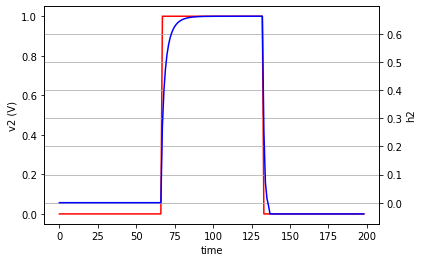

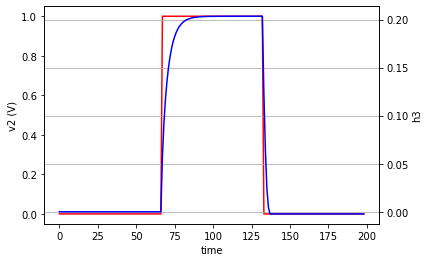

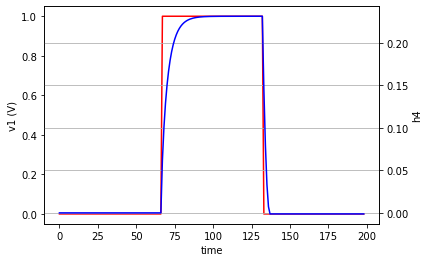

In [32]:
t0 = 0
tf = 199
h = 1
t = np.arange(t0, tf, h)

x0 = np.array([[0], [0], [0], [0]])

z_x = np.zeros((len(x0), len(t)-1))
x = x0.copy()
x = np.append(x, z_x, axis=1)


ux = 1 * np.append(np.append(np.zeros((math.floor(len(t)/3+1), 1)), np.full((math.floor(len(t)/3), 1), 1)), 
                   np.zeros((math.floor(len(t)/3), 1)))
uy = ux
print(len(ux))
run_rk(t.copy(), x.copy(), ux.copy(), uy.copy(), h)

## Senoidal

Com uma entrada senoidal, é possível perceber que o sistema acompanha, embora com uma certa demora, o sinal de entrada, e se esvazia assim que ele diminui. 

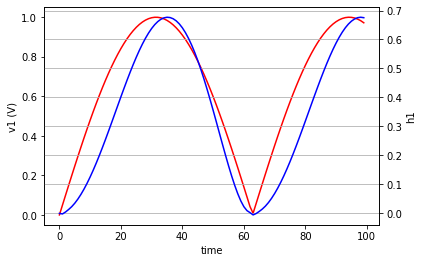

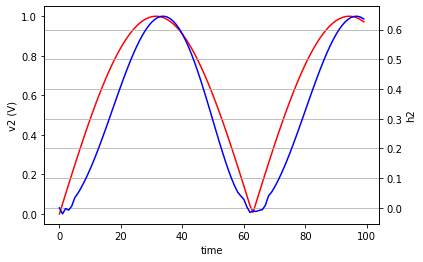

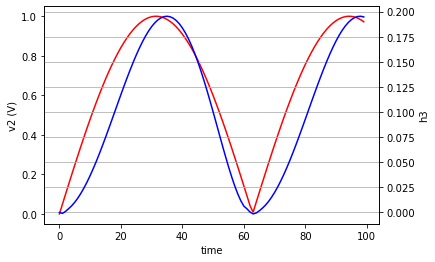

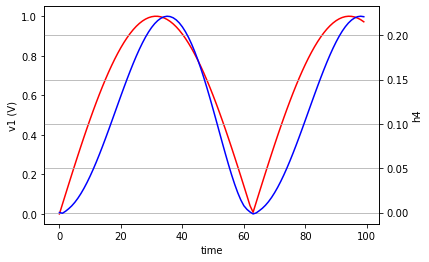

In [41]:
t0 = 0
tf = 100
h = 1
t = np.arange(t0, tf, h)

x0 = np.array([[0], [0], [0], [0]])

z_x = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, z_x, axis=1)


ux = 1 * abs(np.sin(np.array(t * 0.05))) 
uy = ux
run_rk(t.copy(), x.copy(), ux.copy(), uy.copy(), h)

## Senoidal de maior frequência

Com um sinal senoidal de maior frequência, percebe-se que o sistema não se esvazia completamente antes que o sinal aumente novamente. 

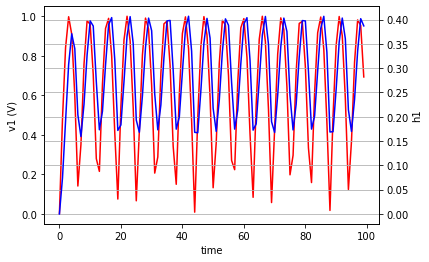

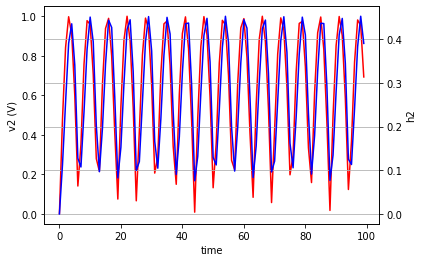

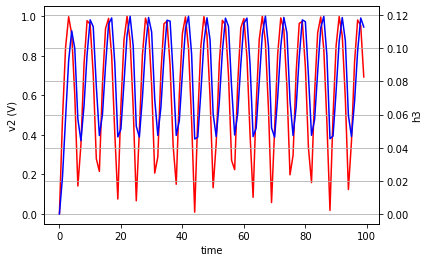

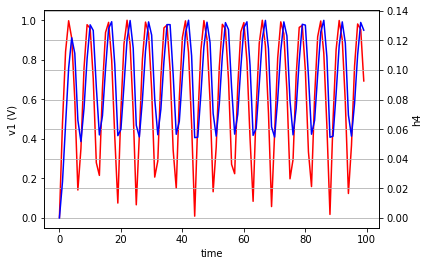

In [48]:
t0 = 0
tf = 100
h = 1
t = np.arange(t0, tf, h)

x0 = np.array([[0], [0], [0], [0]])

z_x = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, z_x, axis=1)


ux = 1 * abs(np.sin(np.array(t * 0.5))) 
uy = ux
run_rk(t.copy(), x.copy(), ux.copy(), uy.copy(), h)

## Aleatório

Com uma entrada aleatória, é possível perceber a dinâmica já descrita anteriormente do sistema, que responde de forma quase instantânea às variações da entrada. Variações rápidas demais, entretanto, dificultam o esvaziamento dos tanques.

400


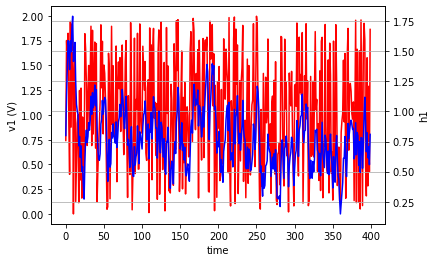

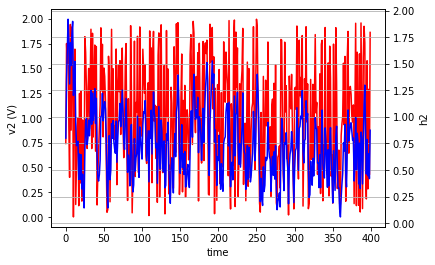

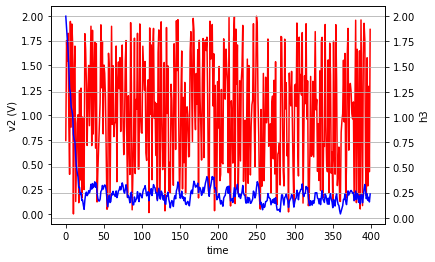

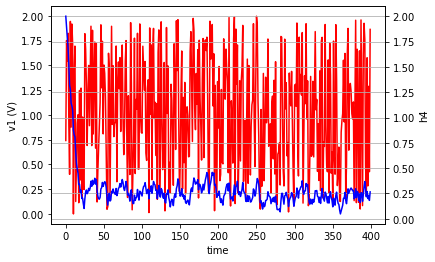

In [49]:
t0 = 0
tf = 400
h = 1
t = np.arange(t0, tf, h)

x0 = np.array([[.8], [.8], [2], [2]])

z_x = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, z_x, axis=1)


print(len(t))
ux = 2* np.random.rand(len(t))
uy = ux
run_rk(t.copy(), x.copy(), ux.copy(), uy.copy(), h)

# Modelo não-linear

## Princípio da superposição

Pelo princípio da superposição, espera-se que ele atenda a duas propriedades:
- Aditividade: F(x1 + x2) = F(x1) + F(x2) 
- Homogeneidade: F(ax) = aF(x) 

Se qualquer uma dessas propriedades não for atendida, o modelo não pode ser considerado linear.

## Demonstração com a função degrau

Se o modelo for linear, um degrau de amplitude cinco deve gerar uma saída de amplitude cinco vezes maior, o que não se observa nos gráficos a seguir.

### Degrau de amplitude 1

L: 20; R: 180


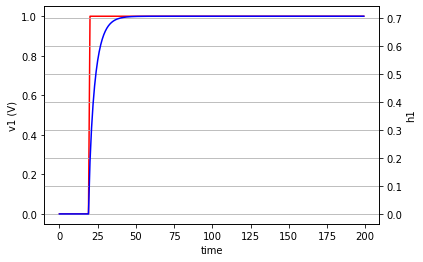

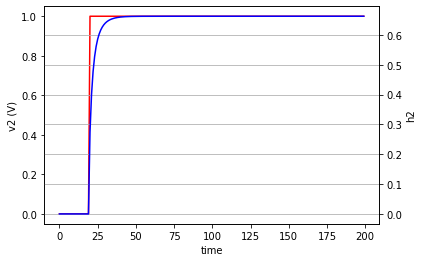

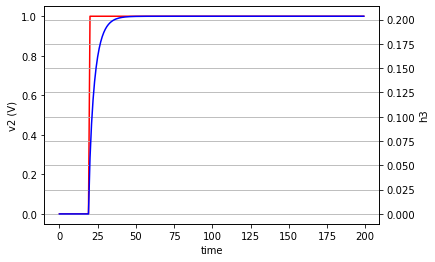

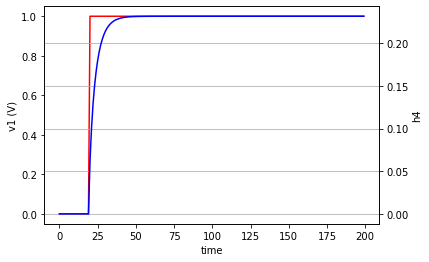

In [51]:
t0 = 0
tf = 200
h = 1
t = np.arange(t0, tf, h)

x0 = np.array([[0], [0], [0], [0]])

z_x = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, z_x, axis=1)


left_size = math.floor(len(t)/10)
right_size = math.floor(len(t) - len(t)/10)
print(f'L: {left_size}; R: {right_size}')
left = np.zeros((left_size, 1))
right = np.ones(right_size)
# print(f'L: {left}; R: {right}')
ux = 1 * np.append(left,right)
uy = ux
run_rk(t.copy(), x.copy(), ux.copy(), uy.copy(), h)

### Degrau de amplitude 5

L: 20; R: 180


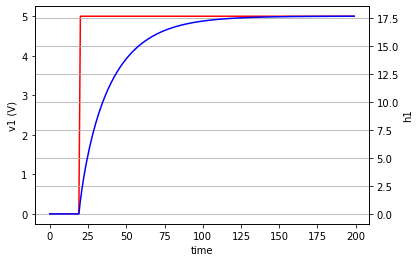

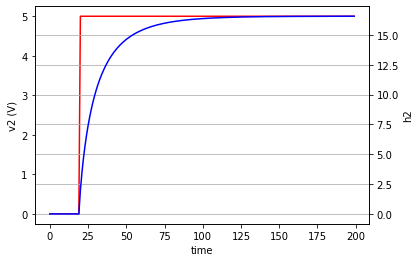

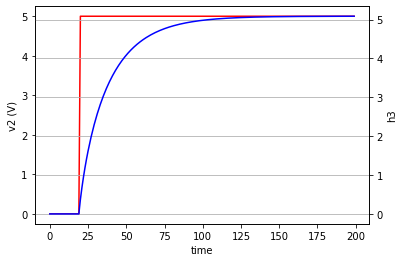

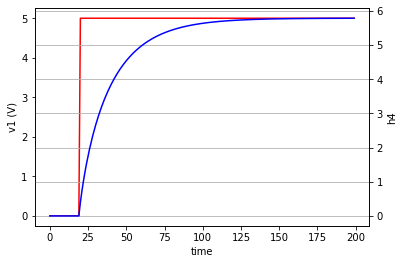

In [52]:
t0 = 0
tf = 200
h = 1
t = np.arange(t0, tf, h)

x0 = np.array([[0], [0], [0], [0]])

z_x = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, z_x, axis=1)


left_size = math.floor(len(t)/10)
right_size = math.floor(len(t) - len(t)/10)
print(f'L: {left_size}; R: {right_size}')
left = np.zeros((left_size, 1))
right = np.ones(right_size)
# print(f'L: {left}; R: {right}')
ux = 5 * np.append(left,right)
uy = ux
run_rk(t.copy(), x.copy(), ux.copy(), uy.copy(), h)

## Pontos de operação diferentes

Com mudanças nos pontos de operação, percebe-se que, ao aumentar o sinal de entrada, o sistema responde cada vez mais devagar. Isso demonstra uma dinâmica não-linear do sistema.

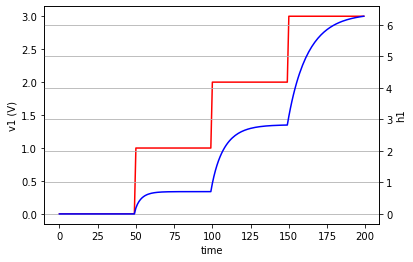

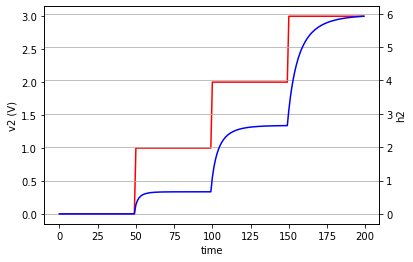

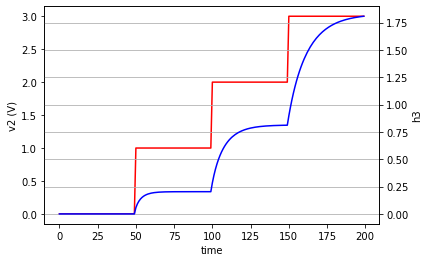

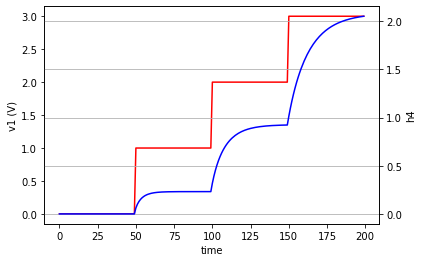

In [57]:
t0 = 0
tf = 200
h = 1
t = np.arange(t0, tf, h)

x0 = np.array([[0], [0], [0], [0]])

z_x = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, z_x, axis=1)

ux = np.zeros((len(t), 1))

for i in range(len(t)):
    if(i < len(t)/4):
        ux[i] = 0
    elif(i >= len(t)/4) and (i < len(t)/2):
        ux[i] = 1
    elif(i >= len(t)/2) and (i < 3* len(t)/4):
        ux[i] = 2
    else:
        ux[i] = 3

uy = ux
run_rk(t.copy(), x.copy(), ux.copy(), uy.copy(), h)